In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.graphics.tsaplots as F
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from arima_model import arima_model
from scipy.stats import boxcox


READING DAATA----------------------------------------------------------------------------------

In [2]:
df_d=pd.read_csv("/home/jack/data_mining/PROJECT/data/day.csv")
d_s=df_d.sample(n=3,replace=False,random_state=42)#n=3 (show 3 rows random) repalce=Fals the sample rows are unique random_state
#so I can generate same result again and again
print(d_s)

     instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
703      704  2012-12-04       4   1    12        0        2           1   
33        34  2011-02-03       1   0     2        0        4           1   
300      301  2011-10-28       4   0    10        0        5           1   

     weathersit      temp     atemp       hum  windspeed  casual  registered  \
703           1  0.475833  0.469054  0.733750   0.174129     551        6055   
33            1  0.186957  0.177878  0.437826   0.277752      61        1489   
300           2  0.330833  0.318812  0.585833   0.229479     456        3291   

      cnt  
703  6606  
33   1550  
300  3747  


In [17]:
df_h=pd.read_csv("/home/jack/data_mining/PROJECT/data/hour.csv")
d_hs=df_h.sample(n=3,replace=False,random_state=42)
print(d_hs)

       instant      dteday  season  yr  mnth  hr  holiday  weekday  \
12830    12831  2012-06-23       3   1     6  19        0        6   
8688      8689  2012-01-02       1   1     1  20        1        1   
7091      7092  2011-10-28       4   0    10   2        0        5   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
12830           0           1  0.80  0.6970  0.27     0.1940     185   
8688            0           1  0.24  0.2273  0.41     0.2239       5   
7091            1           1  0.32  0.3030  0.66     0.2836       1   

       registered  cnt  
12830         240  425  
8688           83   88  
7091            3    4  


In [ ]:
# def find_cato(data):
#     catagorical=[]
#     columns=data.columns
#     thresh_hold=len(data)*0.2
#     dt=['int64','object']
#     for c in columns:
#         dtype=data[c].dtype
#         dtype=str(dtype)
#         uni=np.unique(data[c])
#         if 2<len(uni)<thresh_hold or dtype==dt:
#             catagorical.append(c)
#     return catagorical
            
        

SETING INDEX AS DATAE TIME AND ONE-HOT ENCODING OUTLIERS

In [25]:
df_d['dteday']=pd.to_datetime(df_d['dteday'])
df_h['dteday']=pd.to_datetime(df_h['dteday'])

In [26]:
df_d.set_index("dteday",inplace=True)
df_h.set_index("dteday",inplace=True)

In [27]:
def encoder(df_h,df_d):
    encoded_h = pd.get_dummies(df_h, columns=['yr','hr','season','mnth','weekday','weathersit'
    ])
    encoded_d = pd.get_dummies(df_d, columns=['yr','season','mnth','weekday','weathersit'
    ])
    return encoded_d,encoded_h

In [28]:
print(df_d.head())


            instant  season  yr  mnth  holiday  weekday  workingday  \
dteday                                                                
2011-01-01        1       1   0     1        0        6           0   
2011-01-02        2       1   0     1        0        0           0   
2011-01-03        3       1   0     1        0        1           1   
2011-01-04        4       1   0     1        0        2           1   
2011-01-05        5       1   0     1        0        3           1   

            weathersit      temp     atemp       hum  windspeed  casual  \
dteday                                                                    
2011-01-01           2  0.344167  0.363625  0.805833   0.160446     331   
2011-01-02           2  0.363478  0.353739  0.696087   0.248539     131   
2011-01-03           1  0.196364  0.189405  0.437273   0.248309     120   
2011-01-04           1  0.200000  0.212122  0.590435   0.160296     108   
2011-01-05           1  0.226957  0.229270  0.436957

In [29]:
print(df_h.head())

            instant  season  yr  mnth  hr  holiday  weekday  workingday  \
dteday                                                                    
2011-01-01        1       1   0     1   0        0        6           0   
2011-01-01        2       1   0     1   1        0        6           0   
2011-01-01        3       1   0     1   2        0        6           0   
2011-01-01        4       1   0     1   3        0        6           0   
2011-01-01        5       1   0     1   4        0        6           0   

            weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
dteday                                                                          
2011-01-01           1  0.24  0.2879  0.81        0.0       3          13   16  
2011-01-01           1  0.22  0.2727  0.80        0.0       8          32   40  
2011-01-01           1  0.22  0.2727  0.80        0.0       5          27   32  
2011-01-01           1  0.24  0.2879  0.75        0.0       3        

In [30]:
df_d.info()
print(f"number of rows: {len(df_d)}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   season      731 non-null    int64  
 2   yr          731 non-null    int64  
 3   mnth        731 non-null    int64  
 4   holiday     731 non-null    int64  
 5   weekday     731 non-null    int64  
 6   workingday  731 non-null    int64  
 7   weathersit  731 non-null    int64  
 8   temp        731 non-null    float64
 9   atemp       731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  casual      731 non-null    int64  
 13  registered  731 non-null    int64  
 14  cnt         731 non-null    int64  
dtypes: float64(4), int64(11)
memory usage: 91.4 KB
number of rows: 731


In [31]:
df_h.info()
print(f"number of rows: {len(df_h)}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 to 2012-12-31
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  casual      17379 non-null  int64  
 14  registered  17379 non-null  int64  
 15  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12)
memory usage: 2.3 MB
number of rows: 17379


In [32]:
df_d.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [33]:
df_h.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [34]:
encoded_d,encoded_h=encoder(df_d=df_d,df_h=df_h)

HOW 'CNT' change along DATE---------------------------------------------------------------------------------

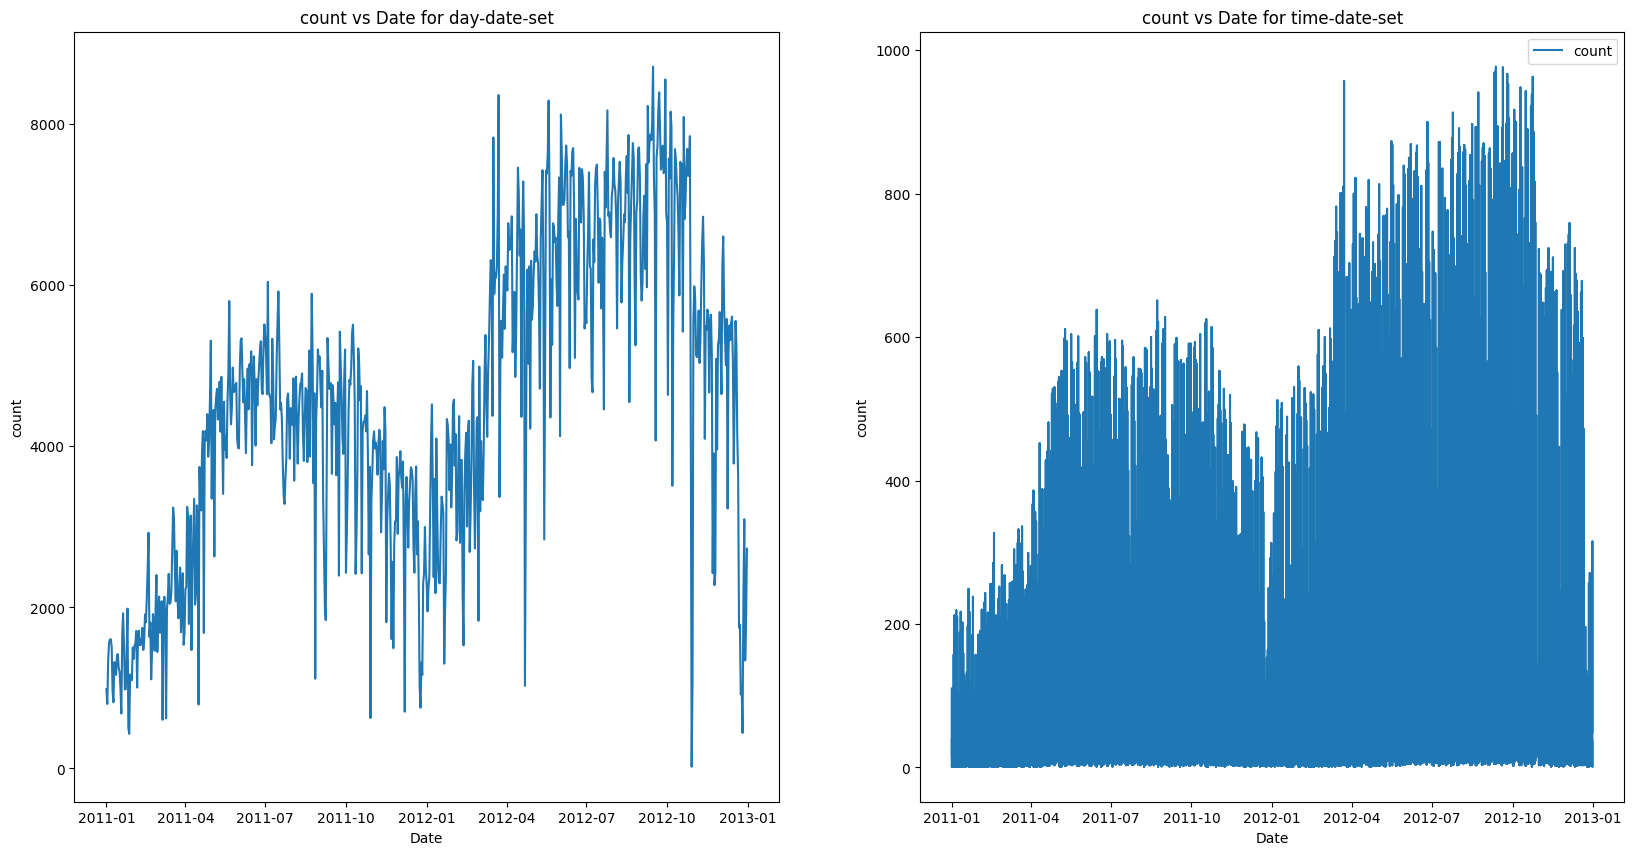

In [35]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.plot(encoded_d.index,encoded_d['cnt'],label="count")
ax2.plot(encoded_h.index,encoded_h['cnt'],label='count')
ax1.set_ylabel("count")
ax1.set_xlabel("Date")
ax1.set_title("count vs Date for day-date-set")

ax2.set_ylabel("count")
ax2.set_xlabel("Date")
ax2.set_title("count vs Date for time-date-set")
plt.legend()
plt.show()

Checking seasonality for 'CNT' IN BOTH DATA SET---------------------------------------------------------------------

period=7 for weekly seasonality

In [41]:
def plot_seasonality(data,period,feature,name,model='additive'):
    plt.clf()  # Clear any existing figures
    additive_result = seasonal_decompose(data[feature], model=model, period=period)
    additive_result.plot()
    plt.title(f'Additive Decomposition_{name}')
    plt.show()

<Figure size 640x480 with 0 Axes>

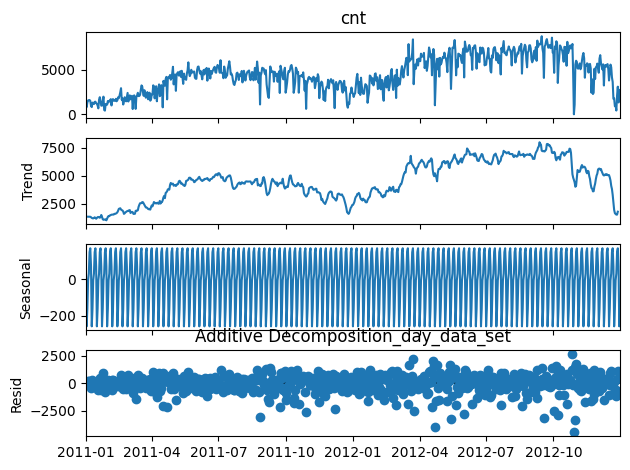

In [42]:
plot_seasonality(encoded_d,period=7,feature='cnt',name='day_data_set')

<Figure size 640x480 with 0 Axes>

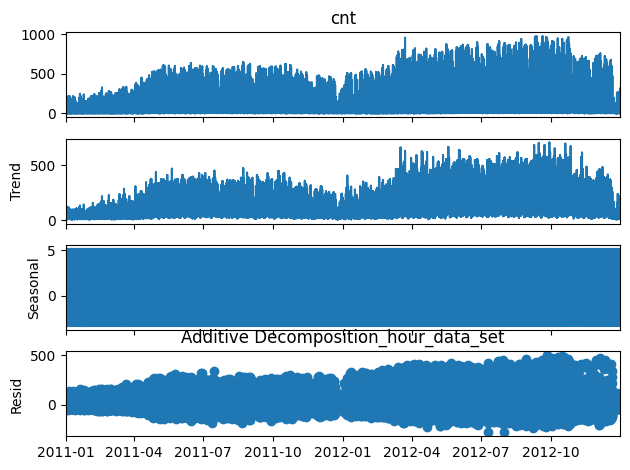

In [43]:
plot_seasonality(encoded_h,period=7,feature='cnt',name='hour_data_set')

Statistical stationary or non-stationary check-----------------------------------------------------------------------

In [44]:
def adf_test(series, feature_name='cnt'):
    
    clean_data=series[feature_name].replace([np.inf,-np.inf],np.nan).dropna()
    I=0
    result = adfuller(clean_data)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")
        # series[f"{feature_name}_dif_log"]=np.log(series[feature_name].diff())
        # series[f"{feature_name}_dif_log"]=series[f"{feature_name}_dif_log"].replace([np.inf,-np.inf],np.nan).dropna()
        I+=1
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
        if result[0] < value:
            print(f"At {key} level, series is stationary")
    return I

In [45]:
I_d=adf_test(encoded_d,'cnt')

ADF Statistic: -1.8774481444374291
p-value: 0.3427434403392198
Series is not stationary
Critical Value (1%): -3.439503230053971
Critical Value (5%): -2.8655794463678346
Critical Value (10%): -2.5689210707289982


In [52]:
I_h=adf_test(encoded_h,'cnt')

ADF Statistic: -6.82291871189509
p-value: 1.9808626277978587e-09
Series is stationary
Critical Value (1%): -3.430727265144117
At 1% level, series is stationary
Critical Value (5%): -2.8617067365231246
At 5% level, series is stationary
Critical Value (10%): -2.5668587495404225
At 10% level, series is stationary


WHEN WE FIRST CHECK STATISTICAL CHECK 'day.csv'->'cnt' failes BUT 'hour.csv'->'cnt' passed

appy box-cox transfrom and log to 'cnt' in encoded_d('day.csv)------------------------------------------------------

In [61]:
encoded_d.dropna(subset=['cnt'], inplace=True)

In [62]:
encoded_d['cnt_b'],la=boxcox(encoded_d['cnt'])

In [63]:
encoded_d['cnt_l']=np.log(encoded_d['cnt'])

we cehck seasonality for period=7 that means 7 day cycle do .diff(7) to make mean constant----------------------------------------

In [64]:
encoded_d['cnt_by_7b']=encoded_d['cnt_b'].diff(7)


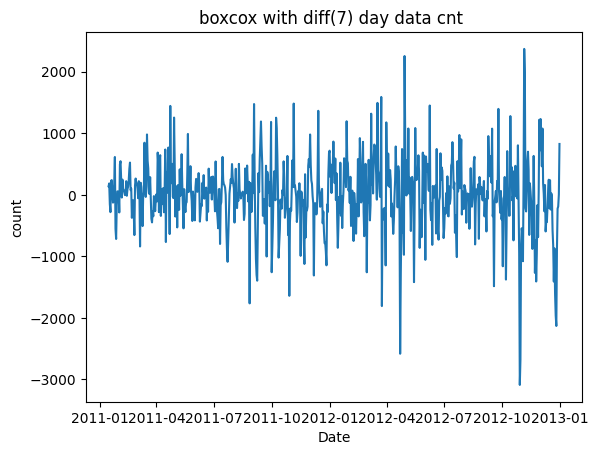

In [65]:
plt.plot(encoded_d.index,encoded_d['cnt_by_7b'],label="after removing weeky seasonality")
plt.xlabel("Date")
plt.ylabel("count")
plt.title("boxcox with diff(7) day data cnt ")
plt.show()

In [66]:
encoded_d['cnt_by_7l']=encoded_d['cnt_l'].diff(7)

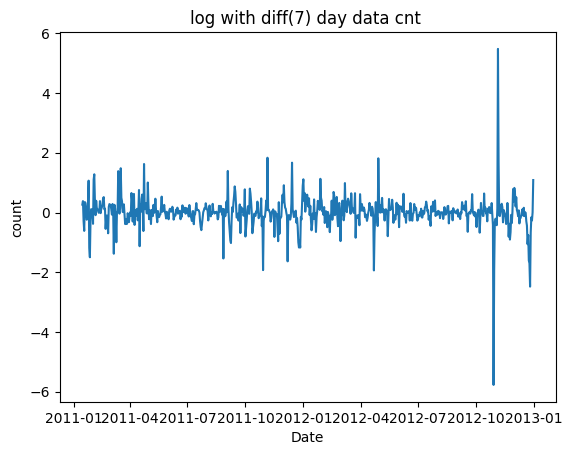

In [67]:
plt.plot(encoded_d.index,encoded_d['cnt_by_7l'],label="after removing weeky seasonality")
plt.xlabel("Date")
plt.ylabel("count")
plt.title("log with diff(7) day data cnt ")
plt.show()

Do statistical stationary check on  fixed 'cnt' in encoded_d "day.csv"---------------------------------------------------

In [68]:
I_d=adf_test(encoded_d,'cnt_by_7l')

ADF Statistic: -8.862272168619263
p-value: 1.471932703446268e-14
Series is stationary
Critical Value (1%): -3.4397804336105198
At 1% level, series is stationary
Critical Value (5%): -2.865701589065464
At 5% level, series is stationary
Critical Value (10%): -2.5689861435625576
At 10% level, series is stationary


In [69]:
I_d=adf_test(encoded_d,'cnt_by_7b')

ADF Statistic: -7.953690853957489
p-value: 3.0774694847273846e-12
Series is stationary
Critical Value (1%): -3.4397804336105198
At 1% level, series is stationary
Critical Value (5%): -2.865701589065464
At 5% level, series is stationary
Critical Value (10%): -2.5689861435625576
At 10% level, series is stationary


now it pass the stationary statistical check (day.csv) encoded

CHECK YEARTLY SEASONALITY FOR  encoded_h (hour.csv)
we cannot check yearly seasonality for encoded_d because it only contain 717 rows to do yearly seasonality check we at least need 730+ rows

In [86]:
len(encoded_d)

717

In [71]:
encoded_d.dropna(subset=['cnt_by_7b'], inplace=True)
encoded_d.dropna(subset=['cnt_by_7l'], inplace=True)

<Figure size 640x480 with 0 Axes>

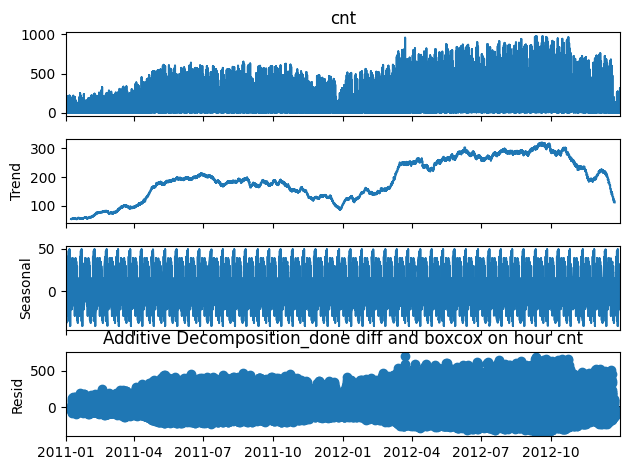

In [84]:
plot_seasonality(encoded_h,period=365,feature='cnt',name="done diff and boxcox on hour cnt")